In [1]:
import requests
import json
import os
from dotenv import load_dotenv
from pathlib import Path


load_dotenv('logstuff.env')


username = os.environ.get('user')
password = os.environ.get('password')

app_id = os.environ.get('app_id')
secret = os.environ.get('secret')
useragent = 'pyDaddy/0.0.1'

auth = requests.auth.HTTPBasicAuth(app_id, secret)

print(auth)

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': username,
        'password': password}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': useragent}

# send our request for an OAuth token
authresponse = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = authresponse.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

print(authresponse)

<Response [200]>


In [2]:
authresponse.json()

{'access_token': '22158216-7LTuOrtJQLQFFhKc4uLtzEJ9h_9M9w',
 'token_type': 'bearer',
 'expires_in': 3600,
 'scope': '*'}

In [3]:
response = requests.get("https://oauth.reddit.com/r/politics/hot",
                   headers=headers)

print(response)
print(response.json())  # let's see what we get


<Response [200]>
{'kind': 'Listing', 'data': {'after': 't3_tk0xls', 'dist': 26, 'modhash': None, 'geo_filter': None, 'children': [{'kind': 't3', 'data': {'approved_at_utc': None, 'subreddit': 'politics', 'selftext': 'Judge Ketanji Brown Jackson testifies at her confirmation hearing to be a Supreme Court Justice before the Senate Judiciary Committee.\n\nEach member of the Senate Judiciary Committee will have a 30 minute period of time for questions and answers.\n\nOrder will alternate from Dem to GOP, and follow the [Member List](https://www.judiciary.senate.gov/about/members) below:\n\n* Chair Senator Dick Durbin D-IL\n* Ranking Member Chuck Grassley R-IA\n* Senator Patrick Leahy D-VT\n* Lindsey Graham R-SC\n* Senator Dianne Feinstein D-CA\n* Senator John Cornyn R-TX\n* Senator Sheldon Whitehouse D-RI\n* Senator Mike Lee R-UT\n* Senator Amy Klobuchar D-MN\n* Senator Ted Cruz R-TX\n* Senator Chris Coons D-DE\n* Senator Ben Sasse R-NE\n* Senator Richard Blumenthal D-CT\n* Senator Josh Ha

In [4]:
count = 0

for post in response.json()['data']['children']:
    print(post['data']['title'])
    print('\n')
    count += 1
    
    
print(count)

Discussion Thread: Confirmation Hearing for Supreme Court Nominee Ketanji Brown Jackson, Day 2 - 03/22/202 | Live 9:00 AM ET


Republican Sen. Mike Braun says Supreme Court was wrong to legalize interracial marriage


Ketanji Brown Jackson schooled GOP senator who ranted about gay marriage | "Well, senator, that is the nature of a right."


Lindsey Graham mocked for storming off after ranting at Ketanji Brown Jackson


Bernie Sanders Calls for the Cancellation of All Medical Debt


'Cowboys For Trump' Founder Guilty Of Illegally Entering Capitol Grounds On Jan. 6


Jackson says Roe v. Wade 'settled law' that is 'relied upon'


Lindsey Graham melts down and storms off during Ketanji Brown Jackson hearing


Top Democrat slams Mitch McConnell as the 'one living senator who has effectively changed the size of the Supreme Court' over his blocking of Obama nominee Merrick Garland


Opinion: Republicans promised 'no circus' at Jackson's hearing. Then the clown car rolled in.


GOP Senator Bea

In [5]:
import praw
# import print

reddit = praw.Reddit(
    client_id=app_id,
    client_secret=secret,
    user_agent=useragent,
    username=username,
    password=password
)
print(reddit) # Output: True

In [6]:
from datetime import datetime
import pandas as pd
from praw.models import MoreComments

url = "https://www.reddit.com/r/worldnews/comments/ti0564/link_found_between_vaccine_resistance_sympathy/"
submission = reddit.submission(url=url)

df = pd.DataFrame(columns = ['Name', 'TotalKarma', 'CommentKarma', 'DateTime', 'AdjustedKarma', 'AdjustedKarmaPercent'])

for comment in submission.comments:
    if isinstance(comment, MoreComments):
        continue
    timestamp = comment.author.created_utc
    convertedDate = datetime.fromtimestamp(timestamp)
    df = df.append({'Name' : comment.author, 'TotalKarma' : comment.author.comment_karma, 'CommentKarma' : comment.score, 
                    'DateTime' : convertedDate, 'AdjustedKarma' : -(comment.score - comment.author.comment_karma),
                   'AdjustedKarmaPercent' : comment.score / comment.author.comment_karma}, ignore_index = True)
    
    print(str(comment.author) + " " + str(comment.author.comment_karma) + " " + str(comment.score) + " " + str(convertedDate))
    
df.head()

ChalkShotHero 14587 7453 2022-03-18 18:55:56
lubeste 4923 514 2018-11-30 00:29:34
RbnMTL 5537 4205 2014-12-28 14:09:57
SpicyPandaBalls 74028 1960 2021-07-01 09:12:10
namesTaken_gfsdgfdsg 997 832 2022-03-10 06:18:36
H3r0d0tu5 6995 39 2019-06-20 09:14:43
_esistgut_ 1404 352 2015-04-01 09:37:40
DigitalHemlock 18904 150 2018-12-07 22:26:45
LegatoSkyheart 175702 8 2012-09-26 11:45:37
MaxiqueBDE 74592 172 2020-01-03 15:42:09
Lockelamora6969 9124 188 2022-01-30 08:41:26
Bleezy79 44667 8 2011-11-09 17:41:23
Thunder_Gun_Xpress 9463 6 2022-02-21 12:22:55
SpikeRosered 275434 6 2012-11-17 21:12:18
JarekBloodDragon 223609 5 2012-02-21 00:22:46
lanaem1 24647 85 2019-05-01 15:26:00
TONEandBARS 15264 4 2011-06-10 23:37:32
LordMaroons 10233 5 2014-05-29 10:25:58
Goferprotocol 30835 53 2012-08-16 12:50:55
heathers1 119352 34 2017-01-21 18:56:59
puremath369 3866 4 2015-01-25 15:39:01
Fuzzyfoot12345 30200 4 2015-09-17 07:56:45
wonderboywilliams 15482 5 2020-01-27 14:08:33
TheRealFrankCostanza 56020 4 2018

,Name,TotalKarma,CommentKarma,DateTime,AdjustedKarma,AdjustedKarmaPercent
0,ChalkShotHero,14587,7453,2022-03-18 18:55:56,7134,0.510934
1,lubeste,4923,514,2018-11-30 00:29:34,4409,0.104408
2,RbnMTL,5537,4205,2014-12-28 14:09:57,1332,0.759437
3,SpicyPandaBalls,74028,1960,2021-07-01 09:12:10,72068,0.026476
4,namesTaken_gfsdgfdsg,997,832,2022-03-10 06:18:36,165,0.834504


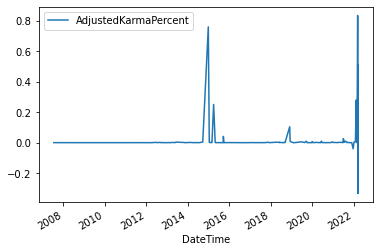

In [7]:
import matplotlib.pyplot as plt
plt.close("all")


yAxis = pd.Series(df['AdjustedKarmaPercent'])
xAxis = pd.Series(df['DateTime'])

ts = pd.Series(yAxis, index = xAxis)
ts.head()

sortdf = df.sort_values(by=['DateTime'])

sortdf.plot(x = 'DateTime', y = 'AdjustedKarmaPercent')
plt.gcf().autofmt_xdate()
plt.show()



In [8]:
from datetime import datetime, timedelta

today = datetime.now()
start_date = today - timedelta(days = 30)
end_date = today

condition = (sortdf['DateTime'] >= start_date) & (sortdf['DateTime'] <= end_date)
newAccounts = sortdf.loc[condition]
newAccounts.head(150)

,Name,TotalKarma,CommentKarma,DateTime,AdjustedKarma,AdjustedKarmaPercent
12,Thunder_Gun_Xpress,9463,6,2022-02-21 12:22:55,9457,0.000634
69,RichWaste6959,99,2,2022-02-23 17:40:04,97,0.020202
74,safetymole,291,2,2022-02-26 18:09:33,289,0.006873
4,namesTaken_gfsdgfdsg,997,832,2022-03-10 06:18:36,165,0.834504
109,No_Adhesiveness_6381,-6,2,2022-03-15 23:40:33,-8,-0.333333
104,No_Adhesiveness_6381,-6,2,2022-03-15 23:40:33,-8,-0.333333
0,ChalkShotHero,14587,7453,2022-03-18 18:55:56,7134,0.510934


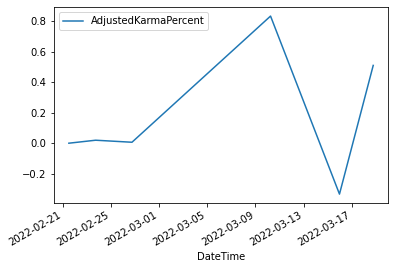

In [9]:
yAxis = pd.Series(newAccounts['AdjustedKarmaPercent'])
xAxis = pd.Series(newAccounts['DateTime'])

ts = pd.Series(yAxis, index = xAxis)
ts.head()


newAccounts.plot(x = 'DateTime', y = 'AdjustedKarmaPercent')
plt.gcf().autofmt_xdate()
plt.show()

In [10]:
response = requests.get("https://oauth.reddit.com/r/politics/hot", headers=headers)

threadList = []


for post in response.json()['data']['children']:
    x = str(post['data']['name'])
    print(x)
    x = x.split('_')
    threadList.append(x[1])

def getSubComments(comment, allComments, verbose=True):

    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
        if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        getSubComments(child, allComments, verbose=verbose)    
    
    
def getAll(r, submissionId, verbose=True):
    submission = r.submission(submissionId)
    comments = submission.comments
    commentsList = []
    getSubComments(comment, commentsList, verbose=verbose)
    return commentsList
  

threadList


t3_tk1uvh
t3_tkeczp
t3_tkb2vy
t3_tk6gyf
t3_tk86b5
t3_tk9rc2
t3_tk94ta
t3_tk83yh
t3_tkagmo
t3_tk3ldt
t3_tkh7ej
t3_tk8voq
t3_tk10vi
t3_tkdxzg
t3_tkdrc9
t3_tkibar
t3_tkg7xj
t3_tk27vd
t3_tk60vh
t3_tk432t
t3_tk22l0
t3_tk44io
t3_tk3izo
t3_tkgigf
t3_tk9ti2
t3_tk0xls


['tk1uvh',
 'tkeczp',
 'tkb2vy',
 'tk6gyf',
 'tk86b5',
 'tk9rc2',
 'tk94ta',
 'tk83yh',
 'tkagmo',
 'tk3ldt',
 'tkh7ej',
 'tk8voq',
 'tk10vi',
 'tkdxzg',
 'tkdrc9',
 'tkibar',
 'tkg7xj',
 'tk27vd',
 'tk60vh',
 'tk432t',
 'tk22l0',
 'tk44io',
 'tk3izo',
 'tkgigf',
 'tk9ti2',
 'tk0xls']

In [11]:
#res = getAll(reddit, 'tk86b5')
threadList = threadList[0:1]
print(threadList)

df2 = pd.DataFrame(columns = ['Name', 'TotalKarma', 'CommentKarma', 'DateTime', 'AdjustedKarma', 'AdjustedKarmaPercent'])    


today = datetime.now()
start_date = today - timedelta(days = 30)

for url in threadList:
    res = reddit.submission(url)
    for comment in res.comments:
        if isinstance(comment, MoreComments):
            continue
        try:
            timestamp = comment.author.created_utc
            convertedDate = datetime.fromtimestamp(timestamp)
            if comment.author is None:
                continue
            elif comment.author.comment_karma == 0:
                continue
            elif convertedDate <= start_date:
                print(convertedDate)
                continue
            else:
                df2 = df2.append({'Name' : comment.author, 'TotalKarma' : comment.author.comment_karma, 'CommentKarma' : comment.score, 
                        'DateTime' : convertedDate, 'AdjustedKarma' : -(comment.score - comment.author.comment_karma),
                        'AdjustedKarmaPercent' : comment.score / comment.author.comment_karma}, ignore_index = True)
        except AttributeError:
            print("Attribute error for " + str(comment))
            continue


        
    
df2.head(500)

['tk1uvh']
2016-08-03 12:21:41
2014-07-31 08:39:10
2022-02-10 13:31:16
2021-02-18 13:42:11
2013-01-19 21:42:25
2016-02-06 18:31:32
2016-09-09 03:40:43
2013-03-25 18:47:54
2013-09-17 22:56:53
2017-05-18 15:48:28
2011-10-04 00:24:15
2014-12-30 16:15:22
2014-11-03 11:45:04
2012-08-02 22:36:33
2019-02-13 20:24:07
2013-07-25 14:37:43
2016-09-09 03:40:43
2018-04-18 12:35:54
2018-10-11 20:21:15
2017-05-29 12:55:29
2021-07-14 03:58:00
2011-09-23 15:05:48
2015-02-18 16:06:26
2020-03-01 14:16:44
2014-01-04 19:43:57
2016-07-12 00:24:43
2012-01-21 10:19:53
2016-02-06 14:50:17
2016-02-06 14:50:17
2009-11-30 16:52:59
2011-12-11 18:29:46
2011-10-04 00:24:15
2011-10-27 15:46:17
2012-05-19 10:17:08
2017-08-05 12:05:05
2021-01-26 20:04:24
2013-03-25 18:47:54
2012-08-17 16:00:59
2012-05-19 10:17:08
2018-04-18 12:35:54
2019-10-10 12:31:20
2014-01-14 12:47:46
2015-09-08 19:16:50
2015-04-20 17:56:29
2011-06-24 21:31:00
2019-11-13 00:27:28
2011-12-11 18:29:46
2020-12-01 09:36:06
2019-08-04 15:00:12
2021-07-1

2016-09-09 03:40:43
2019-07-17 17:23:25
2017-02-15 15:13:19
2021-03-22 09:38:37
2013-03-17 08:47:13
2021-03-22 09:38:37
2013-03-25 18:47:54
2015-03-28 12:51:09
2010-10-29 16:14:17
2012-08-01 22:19:23
2013-01-08 16:58:46
2011-08-14 14:38:45
2015-03-28 12:51:09
2021-03-22 09:38:37
2018-06-17 12:17:45
2021-12-06 01:40:12
2011-06-05 13:12:13
2021-01-22 03:35:05
2021-06-20 15:15:24
2013-07-11 17:17:29
2021-07-14 03:58:00
2014-05-03 05:04:08
2014-11-22 19:49:08
2019-07-23 09:39:27
2016-09-09 03:40:43
2015-03-22 17:39:51
2014-01-14 12:47:46
2021-01-22 03:35:05
2020-11-12 10:10:26
2017-01-05 22:53:38
2021-02-18 13:42:11
2014-05-16 15:41:48


,Name,TotalKarma,CommentKarma,DateTime,AdjustedKarma,AdjustedKarmaPercent
0,DumbDyingRepublicans,174,64,2022-03-20 16:25:03,110,0.367816
1,heretrythiscoffee,1050,44,2022-03-14 18:45:36,1006,0.041905
2,heretrythiscoffee,1050,39,2022-03-14 18:45:36,1011,0.037143
3,freeradioforall,22,1,2022-03-02 09:02:59,21,0.045455
4,celticwomyn,1480,1,2022-03-18 21:22:48,1479,0.000676
5,heretrythiscoffee,1050,1,2022-03-14 18:45:36,1049,0.000952
6,gorillagripsweetie69,16,16,2022-03-22 00:13:34,0,1.000000
7,wholesomeentreat3141,4619,15,2022-03-01 11:18:04,4604,0.003247
8,heretrythiscoffee,1051,1,2022-03-14 18:45:36,1050,0.000951
9,just-regular-I-guess,909,14,2022-02-27 11:57:37,895,0.015402


In [12]:
print(len(df2))

18
